[Cross-corrlation](https://en.wikipedia.org/wiki/Cross-correlation) is a technique widely used in many fields. I won't go to the details of it, since [wikipedia](https://en.wikipedia.org/wiki/Cross-correlation) already gave a very nice introduction. In [seismology](https://en.wikipedia.org/wiki/Seismology), cross correlation is a great tool, for example, to find the amount of shift of one signal recorded different locations on earth, you can use cross correlation; using ambient noise cross correlation, we can find the empirical green's function between two seismic stations; to monitor the nuclear tests around the world, cross correlation also be used to do the pattern recognition on the waveforms recorded. Of course, there are still many other use cases in seismology, therefore, today we will talk about how to do cross correlation in frequency domain. 

You can also do the cross correlation in time domain. But doing this in frequency domain is very simple, and clear, and of course faster as well (I tested both version in the frequency/time domain). 

In [1]:
import numpy as np
from obspy.core import read
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftshift
%matplotlib inline

### Let's create the first signal

For simplicity, we will create the first signal using scipy. We will create a gaussian pulse. 

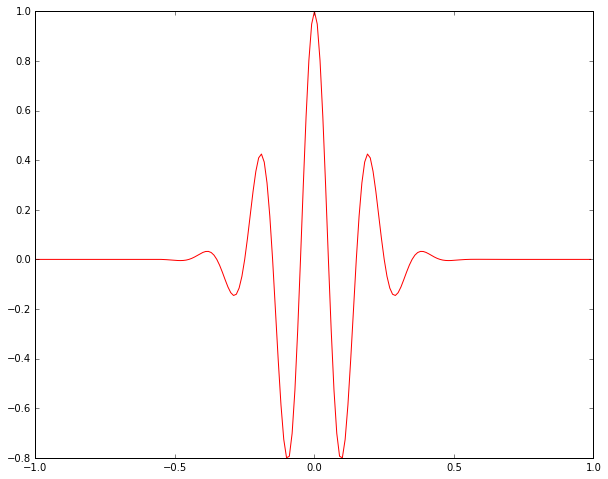

In [7]:
from scipy import signal
t1 = np.linspace(-1, 1, 2 * 100, endpoint=False)
sig1 = signal.gausspulse(t1, fc=5)
plt.figure(figsize=(10,8))
plt.plot(t1, sig1, 'r')
plt.show()

### Create the 2nd signal by simply shift it

For simplicity, we will just shift the first signal by 50 data points, and use it as the second signal. We will use the function we created in the [previous post - shift signal in frequency domain](http://qingkaikong.blogspot.com/2016/03/shift-signal-in-frequency-domain.html) to shift the signal in the frequency domain. 

In [3]:
def nextpow2(i):
    '''
    Find the next power 2 number for FFT
    '''

    n = 1
    while n < i: n *= 2
    return n

def shift_signal_in_frequency_domain(datin, shift):
    '''
    This is function to shift a signal in frequency domain. 
    The idea is in the frequency domain, 
    we just multiply the signal with the phase shift. 
    '''
    Nin = len(datin) 

    # get the next power 2 number for fft
    N = nextpow2(Nin +np.max(np.abs(shift)))

    # do the fft
    fdatin = np.fft.fft(datin, N)

    # get the phase shift, shift here is D in the above explaination
    ik = np.array([2j*np.pi*k for k in xrange(0, N)]) / N 
    fshift = np.exp(-ik*shift)

    # multiple the signal with shift and transform it back to time domain
    datout = np.real(np.fft.ifft(fshift * fdatin))

    # only get the data have the same length as the input signal
    datout = datout[0:Nin]

    return datout

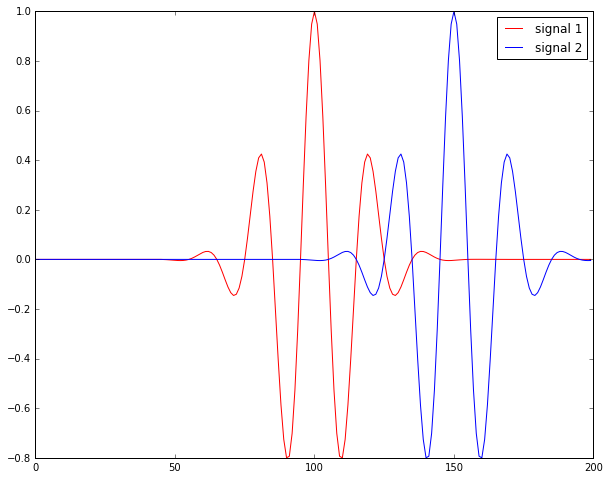

In [4]:
# This is the amount we will move
nShift = 50

# generate the 2nd signal
sig2 = shift_signal_in_frequency_domain(sig1, nShift)

# plot two signals together
plt.figure(figsize=(10,8))
plt.plot(sig1, 'r', label = 'signal 1')
plt.plot(sig2, 'b', label = 'signal 2')
plt.legend()
plt.show()

## Frequency domain cross correlation

Shift a signal in the frequency domain is quite simple. 

1. zero-pad the input signals or apply a taper as we talked [last week](http://qingkaikong.blogspot.com/2016/10/signal-processing-why-do-we-need-taper.html). (I didn't do this, since I know my two signal is zero at both ends, so I skip it)
2. take the FFT of both signals
3. multiply the first signal, and the reverse of the signal (or the conjugate, note that in the frequency domain, the complex conjugation is equivalent to time reversal in the time domain)
4. do the inverse FFT and get the shift

reference:  
[stackexchange](http://dsp.stackexchange.com/questions/736/how-do-i-implement-cross-correlation-to-prove-two-audio-files-are-similar)

In [5]:
 def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    
    # flip the signal of y
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))

    return fftshift(cc)
 
# shift &lt; 0 means that y starts 'shift' time steps before x 
# shift &gt; 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    # we make sure the length of the two signals are the same
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift


In [6]:
calculate_shift = compute_shift(sig1, sig2)
print('The shift we get from cross correlation is %d, the true shift should be 50'%calculate_shift)

The shift we get from cross correlation is 50, the true shift should be 50
